In [1]:
# Install libraries

%%capture

! pip install "flaml[ts_forecast]"

In [2]:
# Download the dataset

%%capture

! rm -rf *
! gdown --id 15vtwJVePVrbhzcS2gr4xY7qWOPi3Hfzo
! unzip cab.zip
! rm cab.zip

In [3]:
# Import libraries

%%capture

import pandas as pd
import numpy as np
from flaml import AutoML
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import pickle

In [4]:
# Set variables

data_dir = Path("cab")
train_df = pd.read_csv(data_dir/"train.csv", parse_dates=["time"], dtype={"y":"int64"})
test_df = pd.read_csv(data_dir/"test.csv", parse_dates=["time"])

In [5]:
# Print some statistics

print(f"Training set number of rows is : {train_df.shape[0]}")
print(f"From : {train_df.time.min()} To : {train_df.time.max()}")
print("\n")
print(f"Test set number of rows is : {test_df.shape[0]}")
print(f"From : {test_df.time.min()} To : {test_df.time.max()}")

Training set number of rows is : 96331
From : 2021-09-01 00:01:00 To : 2021-11-06 23:59:00


Test set number of rows is : 4320
From : 2021-11-07 00:00:00 To : 2021-11-09 23:59:00


In [6]:
# Find missing rows

missing_rows = pd.date_range(start=train_df.time.min(), end=train_df.time.max(), freq="min").difference(train_df.time)
print(f"Number of missing rows: {len(missing_rows)}")

Number of missing rows: 148


In [7]:
# Adding the missed rows

missing_rows_list = []
for missing_row in missing_rows:
  missing_rows_dict = {}
  missing_rows_dict["time"] = missing_row
  missing_rows_dict["y"] = np.nan
  missing_rows_list.append(missing_rows_dict)

missing_df = pd.DataFrame(missing_rows_list)
missing_df["time"] = pd.to_datetime(missing_df["time"])

# Add the missing rows to the train_df
train_df = pd.concat([train_df, missing_df])
train_df.sort_values(by="time", inplace=True)
train_df.isnull().sum()

time      0
y       148
dtype: int64

In [8]:
# Fill in missing values with linear interpolation

train_df.y = train_df.y.interpolate()
train_df.y = train_df.y.astype("int64")
train_df.isnull().sum()

time    0
y       0
dtype: int64

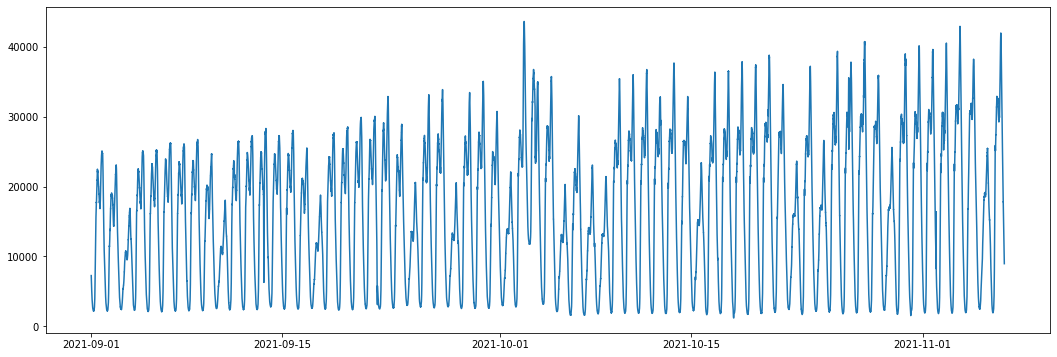

In [10]:
# Plot the time series

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(train_df.time, train_df.y);

In [11]:
X_train = np.arange(train_df.time.min(), train_df.time.max() + datetime.timedelta(minutes=1), dtype='datetime64[m]')
y_train = train_df.y.to_numpy()

In [12]:
# custom evaluation metric

def custom_metric(X_test, y_test, estimator, labels,
                  X_train, y_train, weight_test=None, weight_train=None,
                  config=None, groups_test=None, groups_train=None,
                  ):
    y_pred = estimator.predict(X_test)
    return float(sum(abs(y_test - y_pred)) / sum(y_test)), {}

model = AutoML()

settings = {
    "time_budget": 1800,  # total running time in seconds
    "metric": custom_metric,  # primary metric for validation: 'mape' is generally used for forecast tasks
    "task": 'ts_forecast',  # task type
    "log_file_name": 'ts_forecast.log',  # flaml log file
    "eval_method": "holdout",  # validation method can be chosen from ['auto', 'holdout', 'cv']
    "seed": 7654321,  # random seed
    "estimator_list": ["prophet"],
    "verbose": 0
}

model.fit(X_train=X_train,  # a single column of timestamp
          y_train=y_train,  # value for each timestamp
          period=3*24*60,  # time horizon to forecast
          **settings
          )

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [13]:
# Retrieve best config and best learner

print('Best ML leaner:', model.best_estimator)
print('Best hyperparmeter config:', model.best_config)
print(f'Best evaluation metric on validation data: {model.best_loss}')
print(f'Training duration of best run: {model.best_config_train_time}s')

# Pickle and save the automl object

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

Best ML leaner: prophet
Best hyperparmeter config: {'changepoint_prior_scale': 0.011668554119343547, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 3.0277697214341157, 'seasonality_mode': 'multiplicative', 'FLAML_sample_size': 92159}
Best evaluation metric on validation data: 0.1955331162649059
Training duration of best run: 296.0303406715393s


In [14]:
# Compute predictions of testing dataset

y_pred = model.predict(test_df.time.to_numpy())
print(f"Predicted labels\n{y_pred}")

Predicted labels
0       13639.291050
1       13592.261137
2       13545.409002
3       13498.729121
4       13452.215995
            ...     
4315    11529.017681
4316    11480.074498
4317    11431.356999
4318    11382.859328
4319    11334.575651
Name: yhat, Length: 4320, dtype: float64


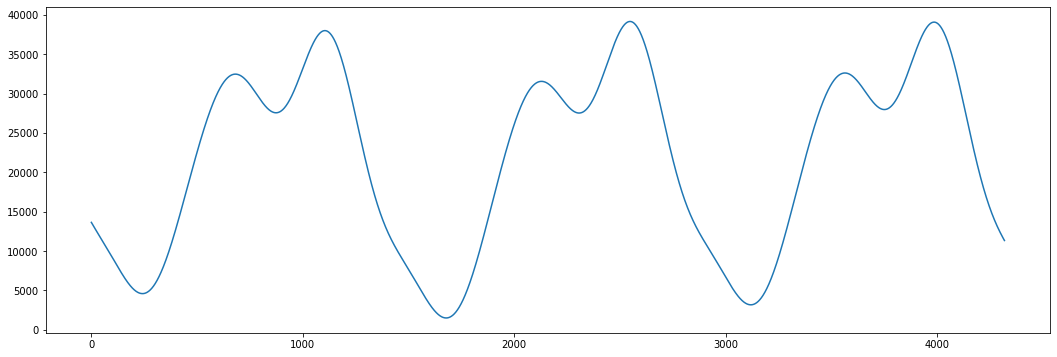

In [15]:
# Visualize the predictions

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(y_pred.index, y_pred.values);

In [20]:
# Prepare the submission file

submission_df = pd.DataFrame()
submission_df["prediction"] = y_pred.values

# Have integers
submission_df["prediction"] = submission_df["prediction"].apply(lambda x: int(x))

# Save the submission file
submission_df.to_csv("output.csv", index=False)
submission_df.head()

,prediction
0,13639
1,13592
2,13545
3,13498
4,13452


Test Fast AI